In [1]:
# Import libraries
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import matplotlib.pyplot as plt 
import seaborn as sns
import torch
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

# Suppress the warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Step 3: Load the 20 Newsgroups Dataset
newsgroups = fetch_20newsgroups(subset='all', shuffle=True, random_state=42)
documents = newsgroups.data  # List of documents
labels = newsgroups.target   # List of labels (categories)
target_names = newsgroups.target_names

print(f"Total Documents: {len(documents)}")
print(f"Categories: {target_names}")

Total Documents: 18846
Categories: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [ ]:

# Download NLTK data files
nltk.download('punkt')       # For tokenization
nltk.download('stopwords')   # For stopword removal
nltk.download('wordnet')     # For lemmatization
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rhars\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rhars\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rhars\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rhars\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Text preprocessing function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stop words and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Join tokens back to a single string
    return ' '.join(tokens)

# Apply preprocessing
newsgroups_data = pd.DataFrame({'text': newsgroups.data, 'target': newsgroups.target})
newsgroups_data['text'] = newsgroups_data['text'].apply(preprocess_text)

In [5]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    newsgroups_data['text'], 
    newsgroups_data['target'], 
    test_size=0.2, 
    random_state=42
)
print(f"Length of X_train: {len(X_train)}")
print(f"Length of X_test: {len(X_test)}")
print(f"Length of y_train: {len(y_train)}")
print(f"Length of y_test: {len(y_test)}")

Length of X_train: 15076
Length of X_test: 3770
Length of y_train: 15076
Length of y_test: 3770


In [6]:
# Initialize BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model = bert_model.to(device)

# Initialize logistic regression model (separate from BERT model)
model = LogisticRegression(max_iter=1000, n_jobs=-1)
def get_bert_embeddings(texts, batch_size=32):
    embeddings = []
    bert_model.eval()  # Use the BERT model here
    
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Generating BERT embeddings"):
            # Get batch of texts
            batch = texts[i:i+batch_size]
            
            # Tokenize and convert to tensors
            encoded = tokenizer.batch_encode_plus(
                batch,
                add_special_tokens=True,
                max_length=128,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            ).to(device)
            
            input_ids = encoded['input_ids']
            attention_mask = encoded['attention_mask']
            
            # Get BERT embeddings
            outputs = bert_model(input_ids, attention_mask=attention_mask)
            # Use mean of last hidden states as document embedding
            last_hidden_states = outputs.last_hidden_state
            doc_embedding = last_hidden_states.mean(dim=1).cpu()
            
            embeddings.append(doc_embedding)
    
    # Concatenate all embeddings
    embeddings = torch.cat(embeddings, dim=0)
    return embeddings.numpy()
# Generate BERT embeddings for train and test sets
print("Generating BERT embeddings for training set...")
X_train_bert = get_bert_embeddings(X_train.tolist())
print("Generating BERT embeddings for test set...")
X_test_bert = get_bert_embeddings(X_test.tolist())

# Train the model
print("Training logistic regression model...")
model = LogisticRegression(max_iter=1000, n_jobs=-1)
model.fit(X_train_bert, y_train)

# Predict on the test set
y_pred = model.predict(X_test_bert)

# Evaluate the model
print("\nModel Evaluation:")
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=newsgroups.target_names))

Generating BERT embeddings for training set...


Generating BERT embeddings: 100%|██████████| 472/472 [58:35<00:00,  7.45s/it] 


Generating BERT embeddings for test set...


Generating BERT embeddings: 100%|██████████| 118/118 [13:25<00:00,  6.83s/it]


Training logistic regression model...

Model Evaluation:
Accuracy: 0.7814

Classification Report:
                          precision    recall  f1-score   support

             alt.atheism       0.66      0.77      0.72       151
           comp.graphics       0.68      0.63      0.65       202
 comp.os.ms-windows.misc       0.60      0.62      0.61       195
comp.sys.ibm.pc.hardware       0.58      0.62      0.60       183
   comp.sys.mac.hardware       0.72      0.66      0.69       205
          comp.windows.x       0.75      0.78      0.77       215
            misc.forsale       0.73      0.71      0.72       193
               rec.autos       0.84      0.79      0.81       196
         rec.motorcycles       0.79      0.86      0.82       168
      rec.sport.baseball       0.92      0.92      0.92       211
        rec.sport.hockey       0.94      0.91      0.93       198
               sci.crypt       0.85      0.85      0.85       201
         sci.electronics       0.72      0.

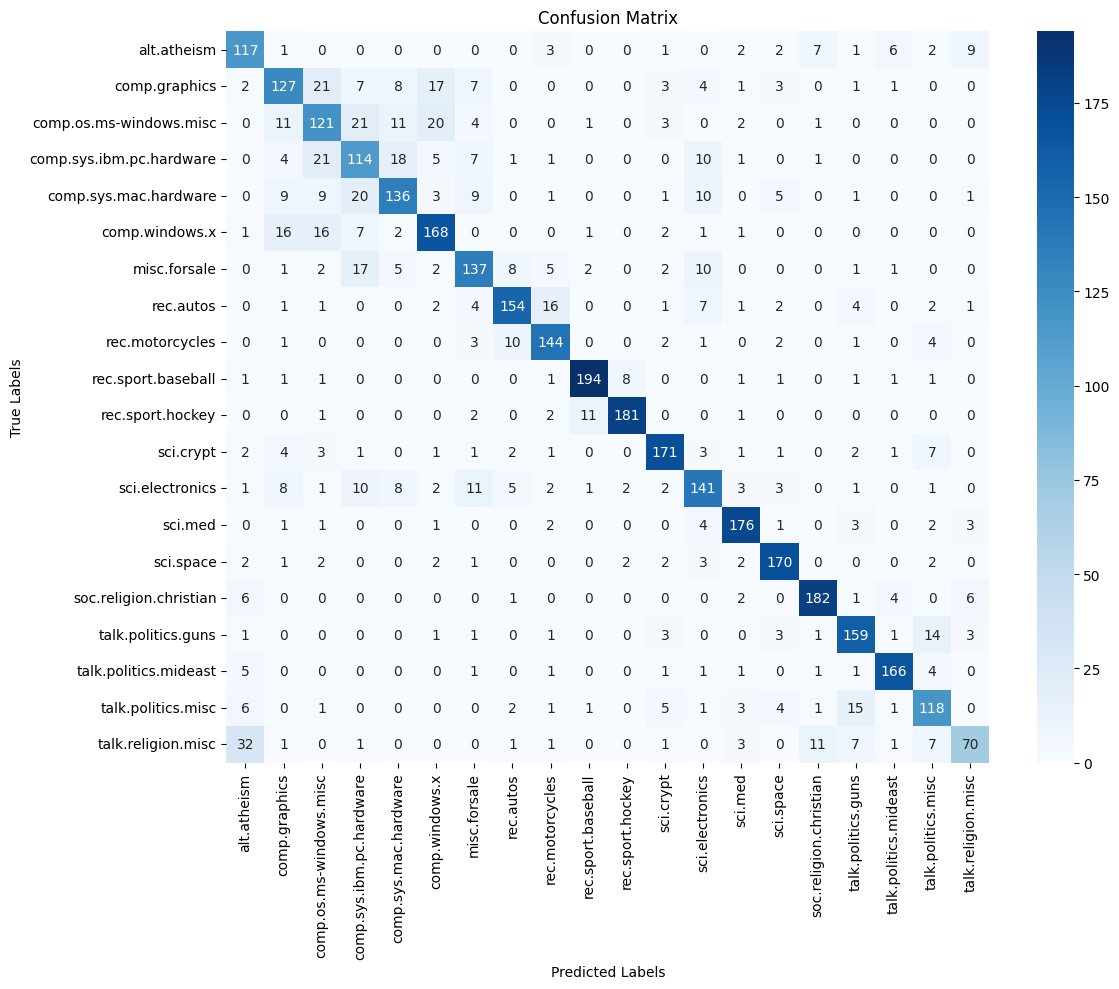

In [7]:
# Plotting the classification report

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = newsgroups.target_names

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [8]:
#step6
# Function to predict new text using BERT embeddings
def predict_new_text(text):
    # Preprocess the text
    text_processed = preprocess_text(text)
    
    # Generate BERT embedding for the text
    bert_model.eval()  # Use the BERT model, not the logistic regression model
    text_embedding = get_bert_embeddings([text_processed])
    
    # Predict the category
    prediction = model.predict(text_embedding)
    
    # Get the category name
    category_name = newsgroups.target_names[prediction[0]]
    
    return category_name

In [12]:
# Step 7
# Take input from the user
test_text = input("Enter the news text to classify: ")

# Predict the category using the function
predicted_category = predict_new_text(test_text)

# Display the result
print(f'\nTest Text: \"{test_text}\"\nPredicted Category: \"{predicted_category}\"')


Generating BERT embeddings: 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]


Test Text: "God, beliefs, and morality debate"
Predicted Category: "soc.religion.christian"


Generating BERT embeddings: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


Top Results for: 'God, beliefs, and morality debate'

Result 1 (Score: 0.7983):
jarefaradayclasvirginiaedu virginia gentleman subject israeli press madness organization university virginia line post earmark form program user type nationality ethnicity fill certain place story true condemn fabrication poster horrible moral despised everyone tpm value truth jesse
---

Result 2 (Score: 0.7879):
edwin gans subject atheism nntppostinghost organization bellnorthern research line
---

Result 3 (Score: 0.7823):
bluelobstercmuedu david hunt subject conversion organization carnegie mellon pittsburgh pa line apr environmentalism paganism user michael covingtonaisun writes would like see christian devote bit less effort bashing paganism figuring present gospel pagan christ answer pagan lot right question unlike materialist deny need spirituality u already answer question without turning christianity case religion whay right presume lecture believe david hunt
---

Result 4 (Score: 0.7795):
aejdcmu

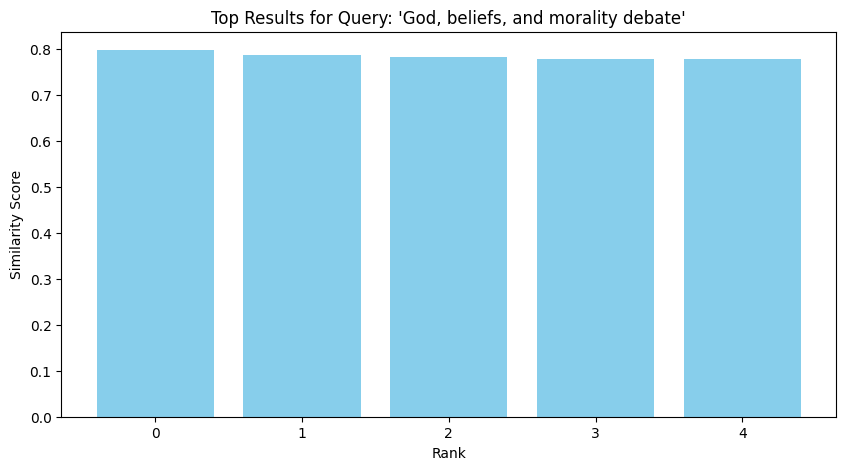

Exiting...


In [13]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

def retrieve_documents(query, top_k=5):
    if not query:
        return []
    preprocessed_query = preprocess_text(query)
    if not preprocessed_query:
        return []
    query_embedding = get_bert_embeddings([preprocessed_query])
    similarities = cosine_similarity(query_embedding, X_train_bert).flatten()
    ranked_indices = np.argsort(similarities)[::-1][:top_k]
    return [(X_train.iloc[i], similarities[i]) for i in ranked_indices]

def visualize_results(results, query):
    scores = [score for (_, score) in results]
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(scores)), scores, color='skyblue')
    plt.title(f"Top Results for Query: '{query}'")
    plt.xlabel("Rank")
    plt.ylabel("Similarity Score")
    plt.show()

while True:
    query = input("\nEnter your search query (or 'exit' to quit): ")
    if query.lower() == 'exit':
        print("Exiting...")
        break
    results = retrieve_documents(query, top_k=5)
    if not results:
        print("No results found. Try another query.")
        continue
    print(f"\nTop Results for: '{query}'")
    for i, (doc, score) in enumerate(results):
        print(f"\nResult {i+1} (Score: {score:.4f}):")
        print(doc[:500])
        print("---")
    visualize_results(results, query)
